In [26]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

from datetime import datetime




In [27]:
#Define paths
currentDir = os.getcwd()
accelerometerDataPath = os.path.join(currentDir, "data", "all_accelerometer_data_pids_13.csv")
tacDataPath = os.path.join(currentDir, "data", "clean_tac")
phoneTypesPath = os.path.join(currentDir, "data", "phone_types.csv")

In [28]:
#Combine clean_tac into one dataframe
csvFiles = glob.glob(os.path.join(tacDataPath, '*.csv'))
print(csvFiles)
tacDataFrames = []

for csvFile in csvFiles:
    tacDataFrames.append(pd.read_csv(csvFile))

['c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\BK7610_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\BU4707_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\CC6740_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\DC6359_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\DK3500_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\HV0618_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\JB3156_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\JR8022_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\MC7070_clean_TAC.csv', 'c:\\Users\\mrcat\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\MJ8002_clean_TAC.csv', 'c:\\Users\\mrcat\\

In [29]:
#Loading data files

tacData = pd.concat(tacDataFrames, ignore_index=True)
accelerometerData = pd.read_csv(accelerometerDataPath)
phoneTypes = pd.read_csv(phoneTypesPath)

In [30]:
#Check dataframes
tacData.head()
accelerometerData.head()
phoneTypes.head()


,pid,phonetype
0,BK7610,iPhone
1,BU4707,iPhone
2,CC6740,Android
3,DC6359,iPhone
4,DK3500,iPhone


In [31]:
#Check for null
tacData.isnull().sum()
accelerometerData.isnull().sum()
phoneTypes.isnull().sum()

pid          0
phonetype    0
dtype: int64

In [32]:
print(tacData)

      timestamp  TAC_Reading
0    1493718714    -0.000482
1    1493720697     0.001573
2    1493721027     0.002144
3    1493721357     0.000877
4    1493721686    -0.001145
..          ...          ...
710  1493797974     0.029049
711  1493799820     0.016286
712  1493801652     0.004243
713  1493803481    -0.001995
714  1493805310    -0.002919

[715 rows x 2 columns]


In [33]:
#Connect accelerometer data with their respective phone types
accelerometerData = accelerometerData.merge(phoneTypes, on='pid')
print(accelerometerData)

                   time     pid         x         y          z phonetype
0                     0  JB3156  0.000000  0.000000   0.000000   Android
1         1493739732016  JB3156 -2.556815  8.312009  14.090558   Android
2         1493739732035  JB3156 -2.499538  8.636412  13.906186   Android
3         1493739732055  JB3156 -2.471458  8.687223  13.677473   Android
4         1493739732075  JB3156 -2.244561  8.832140  13.288850   Android
...                 ...     ...       ...       ...        ...       ...
14057562  1493809885629  DK3500 -0.000800  0.000500   0.006300    iPhone
14057563  1493809885654  DK3500  0.001000 -0.000300   0.006100    iPhone
14057564  1493809885679  DK3500 -0.000200 -0.000100   0.006300    iPhone
14057565  1493809885705  DK3500 -0.001100  0.000100   0.006700    iPhone
14057566  1493809885731  DK3500 -0.000000  0.000100   0.006200    iPhone

[14057567 rows x 6 columns]


In [34]:
#Identify bar crawl events (increased movement)
segmentLength = 60
barCrawlEvents = []

tacData['timestamp'] *= 1000
print(tacData)

print(accelerometerData)

         timestamp  TAC_Reading
0    1493718714000    -0.000482
1    1493720697000     0.001573
2    1493721027000     0.002144
3    1493721357000     0.000877
4    1493721686000    -0.001145
..             ...          ...
710  1493797974000     0.029049
711  1493799820000     0.016286
712  1493801652000     0.004243
713  1493803481000    -0.001995
714  1493805310000    -0.002919

[715 rows x 2 columns]
                   time     pid         x         y          z phonetype
0                     0  JB3156  0.000000  0.000000   0.000000   Android
1         1493739732016  JB3156 -2.556815  8.312009  14.090558   Android
2         1493739732035  JB3156 -2.499538  8.636412  13.906186   Android
3         1493739732055  JB3156 -2.471458  8.687223  13.677473   Android
4         1493739732075  JB3156 -2.244561  8.832140  13.288850   Android
...                 ...     ...       ...       ...        ...       ...
14057562  1493809885629  DK3500 -0.000800  0.000500   0.006300    iPhone
14057563

In [35]:
#Iterate through participants data
for participant_id, participant_data in accelerometerData.groupby('pid'):
    participant_data['magnitude'] = np.sqrt(participant_data['x']**2 + participant_data['y']**2 + participant_data['z']**2)

# Define threshold
threshold = 0.01  # Adjust threshold value as needed

# Identify segments
segments = []
segment_start = None
current_id = None

for index, row in participant_data.iterrows():
    if row['magnitude'] > threshold:
        if segment_start is None:
            segment_start = row['time']
            current_id = row['pid']
    else:
        if segment_start is not None:
            segment_end = row['time']
            segments.append((current_id, segment_start, segment_end))
            segment_start = None
            current_id = None

# Create DataFrame for segments
barCrawlEventsDf = pd.DataFrame(segments, columns=['id', 'segment_start', 'segment_end'])

print(barCrawlEventsDf)

           id  segment_start    segment_end
0      SF3079  1493739196712  1493739196787
1      SF3079  1493739196811  1493739197335
2      SF3079  1493739197373  1493739197553
3      SF3079  1493739197557  1493739198288
4      SF3079  1493739198309  1493739198348
...       ...            ...            ...
23120  SF3079  1493790822313  1493790822348
23121  SF3079  1493790822428  1493790822463
23122  SF3079  1493790822499  1493790822821
23123  SF3079  1493790822880  1493790823547
23124  SF3079  1493790823572  1493790823603

[23125 rows x 3 columns]


In [93]:
# Define heavy drinking episodes based on the TAC threshold (United States legislation threshold 0.08)
tacThreshold_withThresh = 0.08
tolerance_ms = 60 * 10**9
heavyDrinkingEpisodes_withThresh = tacData[tacData['TAC_Reading'] >= tacThreshold_withThresh]
heavyDrinkingEpisodes = tacData[tacData['TAC_Reading'] >= 0]
lightDrinkingEpisodes = tacData[tacData['TAC_Reading'] < tacThreshold_withThresh]

# Merge barCrawlEventsDf with heavyDrinkingEpisodes based on timestamps
aboveMergeData_withThresh = pd.merge_asof(barCrawlEventsDf.sort_values('segment_start'), 
                               heavyDrinkingEpisodes_withThresh.sort_values('timestamp'), 
                               left_on='segment_start', 
                               right_on='timestamp', 
                               direction='nearest',
                               tolerance=tolerance_ms)  # Adjust tolerance as needed

aboveMergeData = pd.merge_asof(barCrawlEventsDf.sort_values('segment_start'), 
                               heavyDrinkingEpisodes.sort_values('timestamp'), 
                               left_on='segment_start', 
                               right_on='timestamp', 
                               direction='nearest',
                               tolerance=tolerance_ms)  # Adjust tolerance as needed

belowMergeData = pd.merge_asof(barCrawlEventsDf.sort_values('segment_start'), 
                               lightDrinkingEpisodes.sort_values('timestamp'), 
                               left_on='segment_start', 
                               right_on='timestamp', 
                               direction='nearest',
                               tolerance=tolerance_ms)  # Adjust tolerance as needed

# Filter mergeData to include only rows where the TAC reading timestamp is within the segment_start and segment_end of barCrawlEventDf
filtered_aboveMergeData_withThresh = aboveMergeData_withThresh[(aboveMergeData_withThresh['timestamp'] >= aboveMergeData_withThresh['segment_start']) & 
                                         (aboveMergeData_withThresh['timestamp'] <= aboveMergeData_withThresh['segment_end'])]

filtered_aboveMergeData = aboveMergeData[(aboveMergeData['timestamp'] >= aboveMergeData['segment_start']) & 
                                         (aboveMergeData['timestamp'] <= aboveMergeData['segment_end'])]

filtered_belowMergeData = belowMergeData[(belowMergeData['timestamp'] >= belowMergeData['segment_start']) & 
                                         (belowMergeData['timestamp'] <= belowMergeData['segment_end'])]

# Print the counts
above_count = filtered_aboveMergeData.shape[0]
below_count = filtered_belowMergeData.shape[0]

print("Number of bar crawl events above 0.08 TAC readings:", above_count)
print("Number of bar crawl events below 0.08 TAC readings:", below_count)

# Determine which category occurs more frequently
if above_count > below_count:
    print("Bar crawl events above 0.08 TAC readings occur more frequently.")
elif above_count < below_count:
    print("Bar crawl events below 0.08 TAC readings occur more frequently.")
else:
    print("Bar crawl events above and below 0.08 TAC readings occur with equal frequency.")

Number of bar crawl events above 0.08 TAC readings: 73
Number of bar crawl events below 0.08 TAC readings: 45
Bar crawl events above 0.08 TAC readings occur more frequently.


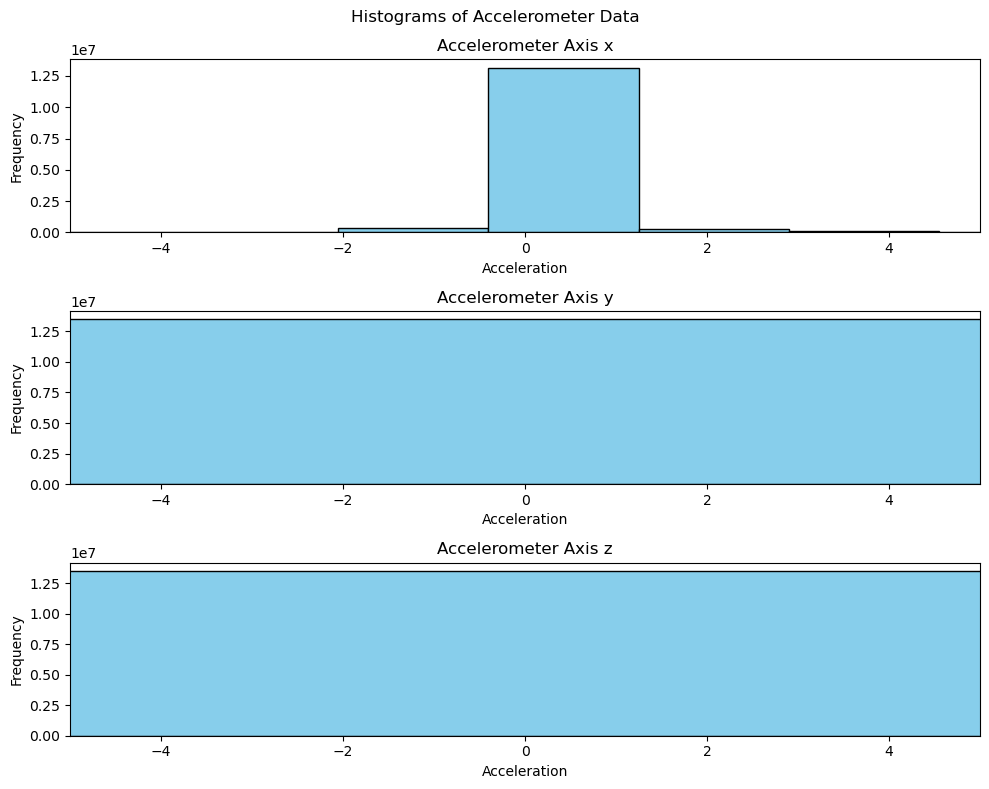

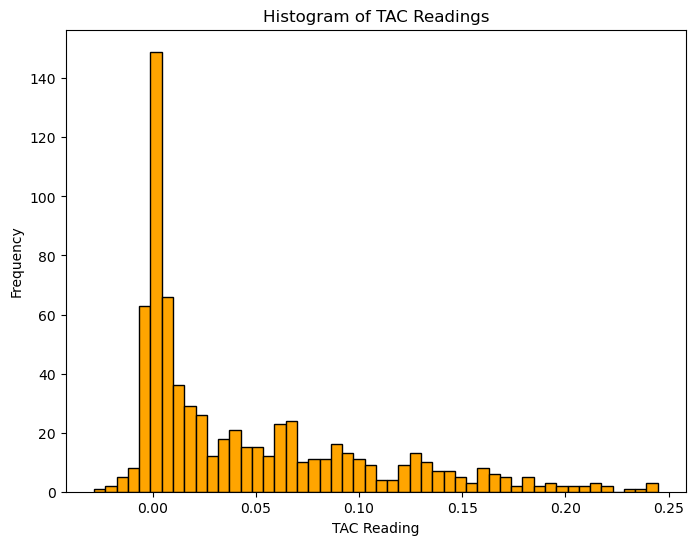

In [37]:
#Set up the figure
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
fig.suptitle('Histograms of Accelerometer Data')

#Plot histograms
for i, axis in enumerate(['x', 'y', 'z']):
    axs[i].hist(accelerometerData[axis], bins=50, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Accelerometer Axis {axis}')
    axs[i].set_xlabel('Acceleration')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlim(-5, 5)

plt.tight_layout()
plt.show()

#TAC histogram
plt.figure(figsize=(8, 6))
plt.hist(tacData['TAC_Reading'], bins=50, color='orange', edgecolor='black')
plt.title('Histogram of TAC Readings')
plt.xlabel('TAC Reading')
plt.ylabel('Frequency')
plt.show()

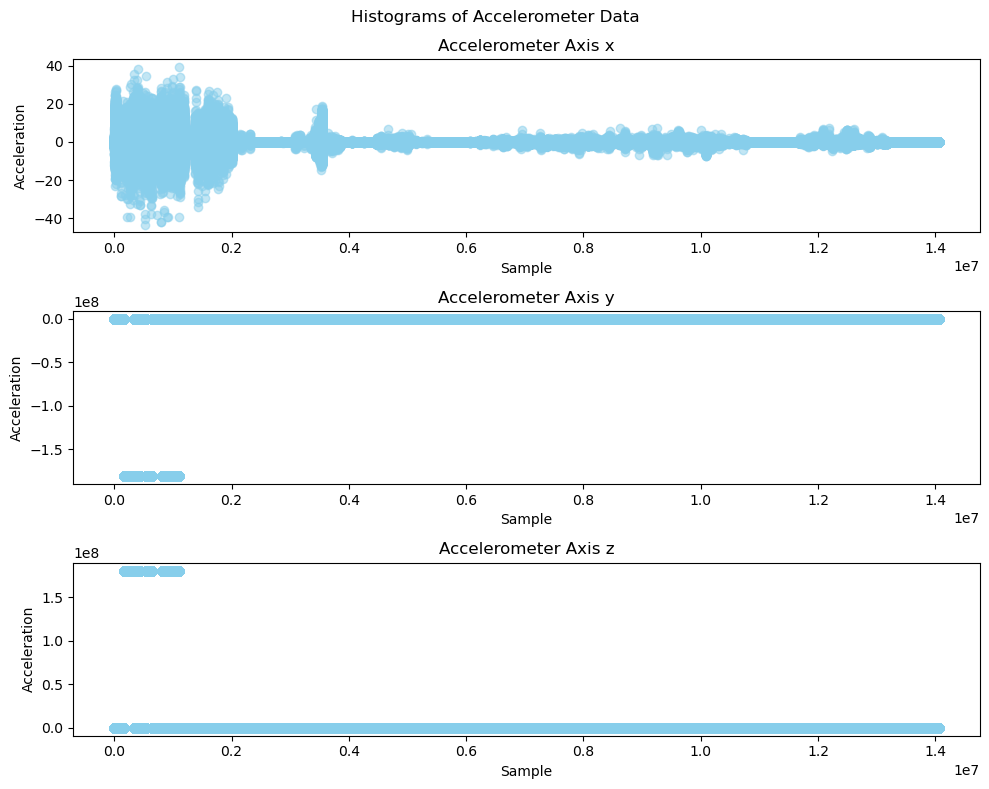

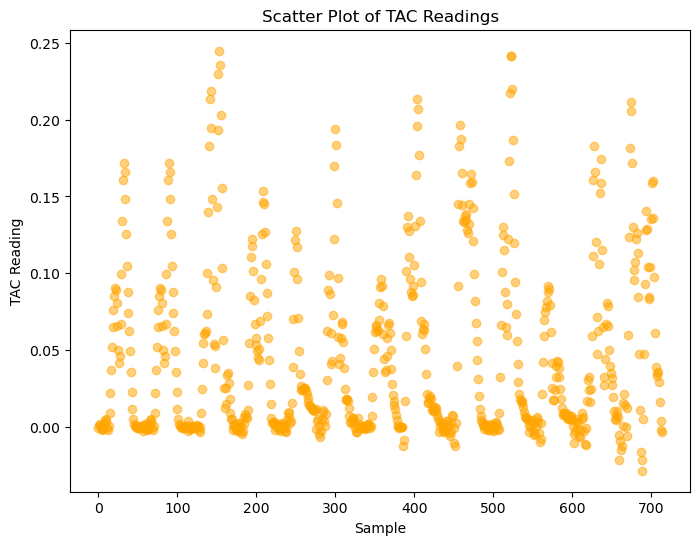

In [38]:
#Set up the figure
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
fig.suptitle('Histograms of Accelerometer Data')

# Plot scatter plots for accelerometer data
for i, axis in enumerate(['x', 'y', 'z']):
    axs[i].scatter(range(len(accelerometerData[axis])), accelerometerData[axis], color='skyblue', alpha=0.5)
    axs[i].set_title(f'Accelerometer Axis {axis}')
    axs[i].set_xlabel('Sample')
    axs[i].set_ylabel('Acceleration')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(range(len(tacData['TAC_Reading'])), tacData['TAC_Reading'], color='orange', alpha=0.5)
plt.title('Scatter Plot of TAC Readings')
plt.xlabel('Sample')
plt.ylabel('TAC Reading')
plt.show()

In [94]:
#EDA
filtered_aboveMergeData['total_time'] = aboveMergeData['segment_end'] - aboveMergeData['segment_start']
filtered_belowMergeData['total_time'] = aboveMergeData['segment_end'] - aboveMergeData['segment_start']
print(filtered_aboveMergeData.columns)
X = filtered_aboveMergeData[['total_time', 'TAC_Reading']]
y = (filtered_aboveMergeData['TAC_Reading'] >= 0.08)
#print(aboveMergeData['heavy_drinking_episode'])

print(X)
print(y)

Index(['id', 'segment_start', 'segment_end', 'timestamp', 'TAC_Reading',
       'total_time'],
      dtype='object')
       total_time  TAC_Reading
303         26997     0.205234
528          2596     0.024861
867        350737     0.088046
984         67802     0.061333
993        244282     0.077807
...           ...          ...
22741         528     0.022695
22773        8825     0.019094
22870        3084     0.008597
22937         733     0.023774
23083       12612     0.050462

[73 rows x 2 columns]
303       True
528      False
867       True
984      False
993      False
         ...  
22741    False
22773    False
22870    False
22937    False
23083    False
Name: TAC_Reading, Length: 73, dtype: bool


E:\Temp\Temp2\ipykernel_23996\946729717.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_aboveMergeData['total_time'] = aboveMergeData['segment_end'] - aboveMergeData['segment_start']
E:\Temp\Temp2\ipykernel_23996\946729717.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_belowMergeData['total_time'] = aboveMergeData['segment_end'] - aboveMergeData['segment_start']


In [95]:
#Handle any NA 
X = X.fillna(X.mean())

In [96]:
#Train-test split
from sklearn.model_selection import train_test_split
from sklearn import  linear_model
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)

print(reg.coef_)
print(reg.intercept_)
print(reg.coef_.shape[0])

reg.fit(X_train,y_train)
reg.score(X_test,y_test)
reg.score(X_test,y_test)

(58, 2)
(15, 2)
(58,)
(15,)
[8.22142651e-07 7.06727521e+00]
-0.1544130082442744
2


0.49636936950447674

In [97]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_reg = LogisticRegression()

logistic_reg.fit(X_train, y_train)

y_pred = logistic_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest = RandomForestClassifier()

random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9333333333333333


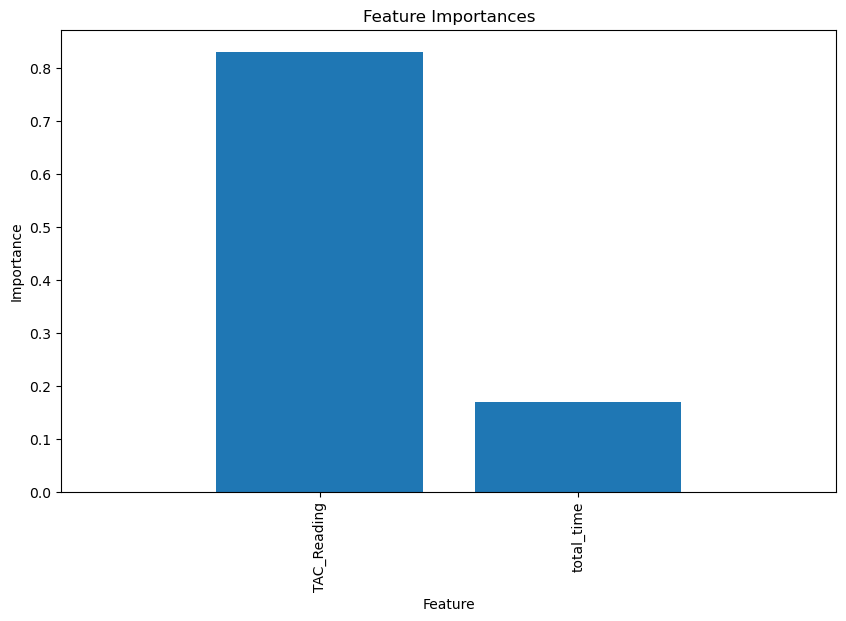

In [99]:
import matplotlib.pyplot as plt

feature_importances = random_forest.feature_importances_

feature_names = X.columns

indices = feature_importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()